# Regridding for generating ocean initial conditions

We should be able to rely on available tools for main regridding task; however, there are a few special elements of the regridding workflow for ocean model inputs that require additional effort:

1. While bilinear remapping is straightforward, conservatitve regridding schemes need the grid corners, thus we need tools to generate the grid files including these.

1. Missing value masks vary as a function of depth in the ocean, but computing a mapping file for each level is too expensive; thus, we use a mapping file for the surface, but renormalize the remapped field to account for a different mask at each level.

1. In some cases it is necessary to remap laterally as well as vertically, possibly extrapolating with depth.

1. When remapping from datasets or other models with different mask, some points on the destination grid can remain "unmapped" and therefore missing; while this might be acceptable for some analyses or visualization applications, it is not acceptable if we are generating initial conditions for model simulations. Thus we require a means to fill unmapped cells.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np

import importlib

import regrid

### demonstrate filling an unmapped region

Generate some pseudo 3D data for demonstration.

In [2]:
def mask_3d(ds):
    nk = len(ds.z_t)
    nj = ds.KMT.shape[0]
    ni = ds.KMT.shape[1]
    
    MASK = (xr.DataArray(np.arange(0,len(ds.z_t)),dims=('z_t')) *
        xr.DataArray(np.ones((nk,nj,ni)),dims=('z_t','nlat','nlon'),
                     coords={'z_t':ds.z_t}))
    MASK = MASK.where(MASK <= ds.KMT-1)
    MASK.values = np.where(MASK.notnull(),1.,0.)
    return MASK
    
def gen_3d_field(ds):
    return (ds.z_t * ds.HT).where(mask_3d(ds) == 1)

In [3]:
dsx1 = xr.open_dataset('/glade/work/mclong/grids/POP_gx1v7.nc')
dsx1 = dsx1.drop([v for v in dsx1.variables if v not in ['z_t','HT','KMT']])

dsx3 = xr.open_dataset('/glade/work/mclong/grids/pop-grid-g37.nc')
dsx3 = dsx3.drop([v for v in dsx3.variables if v not in ['z_t','HT','KMT']])

dsx1.HT.values = np.where(dsx1.KMT > 0,dsx1.HT.values,np.nan)
dsx3.HT.values = np.where(dsx3.KMT > 0,dsx3.HT.values,np.nan)


put a big chunk of missing values in to demonstrate the unmapped-values filling procedure.

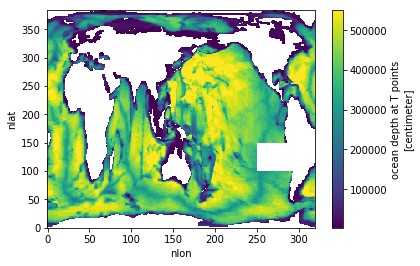

In [4]:
dsx1.HT.values[100:150,250:300] = np.nan

dsx1['x3D'] = gen_3d_field(dsx1)
dsx3['x3D'] = gen_3d_field(dsx3)

dsx1.HT.plot()

In [5]:
clobber = False
method = 'conservative'
src_grid_name = 'POP_gx1v7'
dst_grid_name = 'POP_gx3v7'

R = regrid.regridder(src_grid_name, dst_grid_name, 
                     method = method,                      
                     clobber = clobber)


Here's what the field should nominally look like on the destination grid (only approximately)

### 2D data

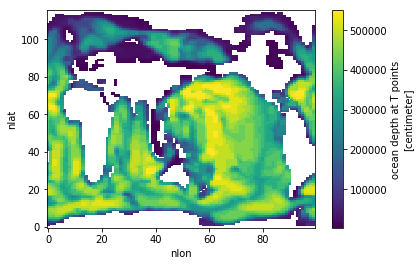

In [6]:
dsx3.HT.plot()

Demonstrate remapping with no masking.

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


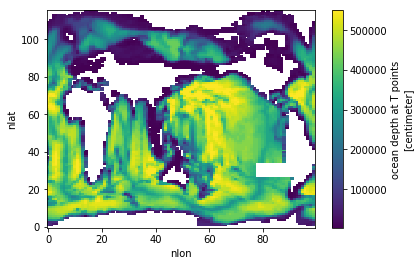

In [7]:
data = R(dsx1.HT, renormalize=True)
data.plot()

Now apply the land mask

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


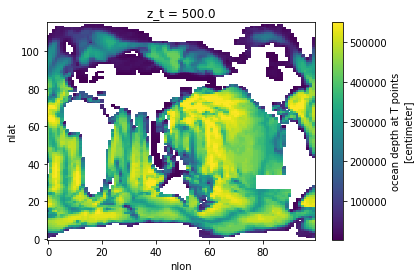

In [8]:
mask = regrid.util.mask_3d_POP(dst_grid_name).isel(z_t=0)
data = R(dsx1.HT, renormalize=True, apply_mask = mask)
data.plot()

Mask and fill

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


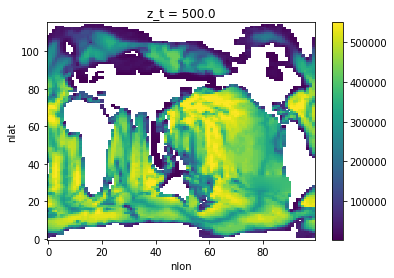

In [9]:
mask = regrid.util.mask_3d_POP(dst_grid_name).isel(z_t=0)
data = R(dsx1.HT, renormalize=True, apply_mask = mask,
         post_method = regrid.util.fill_ocean_POP,
         post_method_kwargs = {'mask': mask,
                               'ltripole': False})
data.plot()

### 3D data

Remap and apply mask.

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


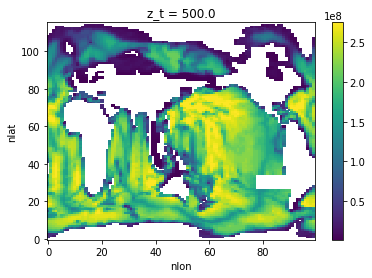

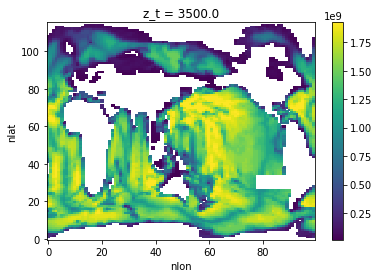

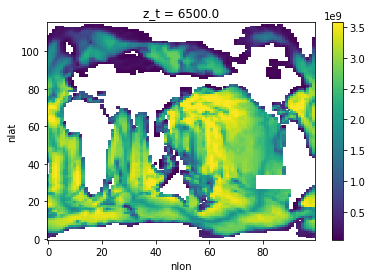

In [10]:
mask = regrid.util.mask_3d_POP(dst_grid_name)
data = R(dsx1.x3D, renormalize=True, apply_mask = mask) 

plt.figure()
data.isel(z_t=0).plot()

plt.figure()
data.isel(z_t=3).plot()

plt.figure()
data.isel(z_t=-10).plot()

Remap to a new vertical coordinate, including out-of-bounds values.

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


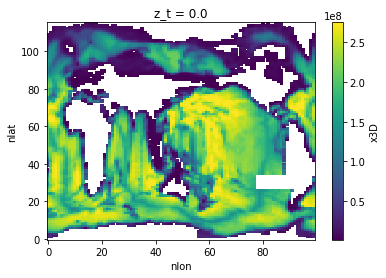

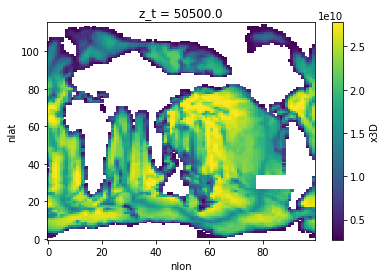

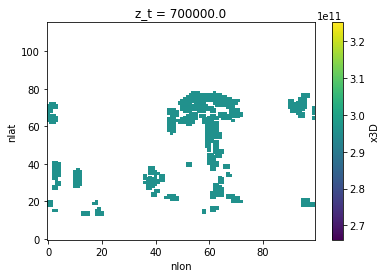

In [12]:
data = R(dsx1.x3D, renormalize=True, 
         interp_coord = {'z_t': np.array([0.,4e2,12e2,505e2,7000e2])}) 

plt.figure()
data.isel(z_t=0).plot()

plt.figure()
data.isel(z_t=3).plot()

plt.figure()
data.isel(z_t=-1).plot()

Mask and fill.

/gpfs/u/home/mclong/p/regrid/regrid/regrid.py:140: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0., data_dst, np.nan)


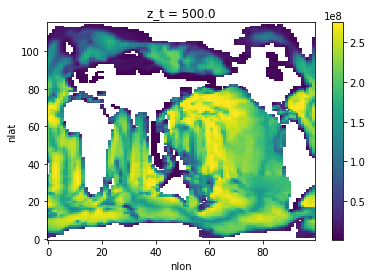

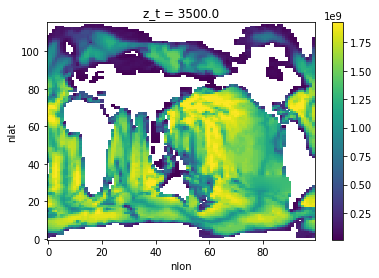

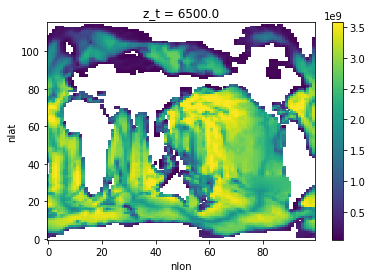

In [13]:
mask = regrid.util.mask_3d_POP(dst_grid_name)
data = R(dsx1.x3D, renormalize=True, 
         apply_mask = mask,
         post_method = regrid.util.fill_ocean_POP,
         post_method_kwargs = {'mask': mask,
                               'ltripole': False})

plt.figure()
data.isel(z_t=0).plot()

plt.figure()
data.isel(z_t=3).plot()

plt.figure()
data.isel(z_t=-10).plot()